## Configs

In [1]:
#Pip installation

# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# # !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install albumentations==0.4.6
# !pip install opencv-python-headless==4.5.2.52

In [1]:
#IMPORTS
import albumentations as A
import cv2
import numpy as np
import os
import glob as glob

#Torch
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt
import time
from xml.etree import ElementTree as et
from tqdm.auto import tqdm
# from google.colab.patches import cv2_imshow

plt.style.use('ggplot')

In [2]:
#Configs

BATCH_SIZE = 2 
NUM_EPOCHS = 2
RESIZE_TO = 400



# Data folders
TRAIN_DIR = '../data/datasets/LU-data/train'
VALID_DIR = '../data/datasets/LU-data/valid'

# location to save model and plots
OUT_DIR = '/RCNN_results'

MODEL_NAME = 'model v0.1'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs


# Dataset information
CLASSES = [
    'BACKGROUND', 'PEDESTRIAN_CROSSING', 'PRIORITY_ROAD', 'PASS_RIGHT_SIDE', '50_SIGN', '70_SIGN', '80_SIGN', 'NO_PARKING',
     'GIVE_WAY', '100_SIGN', 'NO_STOPPING_NO_STANDING', 'STOP', 'WARNING_BAD_ROAD', 'WARNING_DANGER','WARNING_RAIL_CROSSING',
     'WARNING_CROSSING_ROAD', 'WARNING_PEDESTRIANS', 'WARNING', '30_SIGN','WARNING_CHILDREN', 'WARNING_SHARP_CURVES',
     'WARNING_EQUISTARIANS', 'PASS_EITHER_SIDE']
NUM_CLASSES = 23


# Vizualization of results...
VISUALIZE_TRANSFORMED_IMAGES = False

#CUDA Settings
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class Averager:
 # Set everything to 0 when loaded
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Transformation on data...

This will convert the images in our dataset to Tensors.

We can also add any augmentations (Transformations) to the data in here.


example:
[
 * A.Flip(float),
 * A.RandomRotate90(float),
 * A.MotionBlur(p=float),
 * A.MedianBlur(blur_limit=int, p=float),
 * A.Blur(blur_limit=int, p=float),
 * ToTensorV2(p=1.0)
]

In [5]:
def show_transformed_image(train_loader):

    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('sample', sample)

In [6]:
def get_train_transform():
    return A.Compose([ToTensorV2(p=1.0)], 
                     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [7]:
def get_valid_transform():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [8]:
class LUDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f'{self.dir_path}/*.jpg')
        # self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = [image_path.split('\\')[-1] for image_path in self.image_paths]  # Changed since split was in wrong place => __getitem__ dit not work.
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
train_dataset = LUDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = LUDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

# execute datasets.py using Python command from Terminal...
# ... to visualize sample images
# USAGE: python datasets.py
if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = LUDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")
    
    # function to visualize a single sample
    def visualize_sample(image, target):
        box = target['boxes'][0]
        label = CLASSES[target['labels']]
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
        cv2.imshow('image', image)
        cv2.waitKey(0)
        cv2.destroyWindow('image')
        
    NUM_SAMPLES_TO_VISUALIZE = 2
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

Number of training samples: 801
Number of validation samples: 229

Number of training images: 801


In [9]:
# Dataloader

train_dataset = LUDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = LUDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 801
Number of validation samples: 229



In [11]:
dataset = LUDataset(TRAIN_DIR,
                    RESIZE_TO,
                    RESIZE_TO,
                    CLASSES)

print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    box = target['boxes'][0]
    label = CLASSES[target['labels']]
    cv2.rectangle(
        image,
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0), 1
    )
    cv2.putText(
        image, label, (int(box[0]), int(box[1]-5)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
    cv2.imshow("image", image)


NUM_SAMPLES_TO_VISUALIZE = 2
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)

Number of training images: 801


# Faster - RCNN model

In [12]:

def create_model(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [13]:


def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [14]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
            
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list


EPOCH 1 of 2
Training


  0%|          | 0/401 [00:00<?, ?it/s]

ValueError: Expected x_max for bbox (tensor(0.8984), tensor(0.2458), tensor(1.0008), tensor(0.4271), tensor(8)) to be in the range [0.0, 1.0], got 1.0007812976837158.

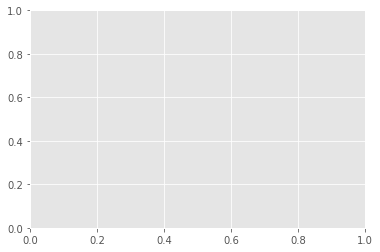

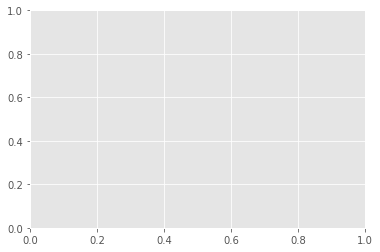

In [15]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_loss_hist = Averager()
val_loss_hist = Averager()

train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

if VISUALIZE_TRANSFORMED_IMAGES:
    show_transformed_image(train_loader)

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    train_loss_hist.reset()
    val_loss_hist.reset()
    # create plot for training progress

    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    if (epoch+1) % SAVE_MODEL_EPOCH == 0:
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0:
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS:
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')